In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [2]:
width = 216
height = 216
num_classes = 2

In [3]:
base_model = tf.keras.models.load_model('./Saved-Models/Locator')

In [4]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 216, 216, 3) 0                                            
__________________________________________________________________________________________________
bl_1 (Rescaling)                (None, 216, 216, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
bl_2 (Conv2D)                   (None, 216, 216, 16) 448         bl_1[0][0]                       
__________________________________________________________________________________________________
bl_3 (MaxPooling2D)             (None, 108, 108, 16) 0           bl_2[0][0]                       
______________________________________________________________________________________________

In [5]:
for layer in base_model.layers:
    if layer.name.startswith('bl_'):
        print(layer.name)
        layer.trainable = False
        
for layer in base_model.layers:
    if layer.name.startswith('bb_'):
        print(layer.name)
        layer.trainable = False

bl_1
bl_2
bl_3
bl_4
bl_5
bl_6
bl_7
bl_8
bb_1
bb_2
bb_3
bb_head


In [6]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 216, 216, 3) 0                                            
__________________________________________________________________________________________________
bl_1 (Rescaling)                (None, 216, 216, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
bl_2 (Conv2D)                   (None, 216, 216, 16) 448         bl_1[0][0]                       
__________________________________________________________________________________________________
bl_3 (MaxPooling2D)             (None, 108, 108, 16) 0           bl_2[0][0]                       
______________________________________________________________________________________________

In [7]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}

In [8]:
classes = ["Circle", "No-Circle"]

base_model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [9]:
TRAINING_CSV_FILE = 'Data/training_data.csv'
TESTING_CSV_FILE = 'Data/testing_data.csv'
TRAINING_IMAGE_DIR = 'Images/Training'
TESTING_IMAGE_DIR = 'Images/Testing'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
testing_image_records = pd.read_csv(TESTING_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
test_image_path = os.path.join(os.getcwd(), TESTING_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))
    
    
    
test_images = []
test_targets = []
test_labels = []

for index, row in testing_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    #img_arr = img_arr/255.0
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(classes.index(class_name))

In [10]:
print(len(train_images))

166


In [11]:
training_epochs = 20

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

In [12]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}

testTargets = {
    "cl_head": test_labels,
    "bb_head": test_targets
}

In [13]:
history = base_model.fit(train_images, trainTargets,
                   validation_data=(test_images, testTargets),
                   batch_size=4,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/20
42/42 [==============================] - 19s 439ms/step - loss: 1.4105 - cl_head_loss: 1.3282 - bb_head_loss: 0.0823 - cl_head_accuracy: 0.5964 - bb_head_accuracy: 0.6627 - val_loss: 0.7598 - val_cl_head_loss: 0.6678 - val_bb_head_loss: 0.0921 - val_cl_head_accuracy: 0.7727 - val_bb_head_accuracy: 0.5909
Epoch 2/20
42/42 [==============================] - 18s 436ms/step - loss: 0.7072 - cl_head_loss: 0.6249 - bb_head_loss: 0.0823 - cl_head_accuracy: 0.8193 - bb_head_accuracy: 0.6627 - val_loss: 0.6208 - val_cl_head_loss: 0.5287 - val_bb_head_loss: 0.0921 - val_cl_head_accuracy: 0.7727 - val_bb_head_accuracy: 0.5909
Epoch 3/20
42/42 [==============================] - 18s 436ms/step - loss: 0.6209 - cl_head_loss: 0.5386 - bb_head_loss: 0.0823 - cl_head_accuracy: 0.8253 - bb_head_accuracy: 0.6627 - val_loss: 0.5224 - val_cl_head_loss: 0.4303 - val_bb_head_loss: 0.0921 - val_cl_head_accuracy: 0.9091 - val_bb_head_accuracy: 0.5909
Epoch 4/20
42/42 [==============================]

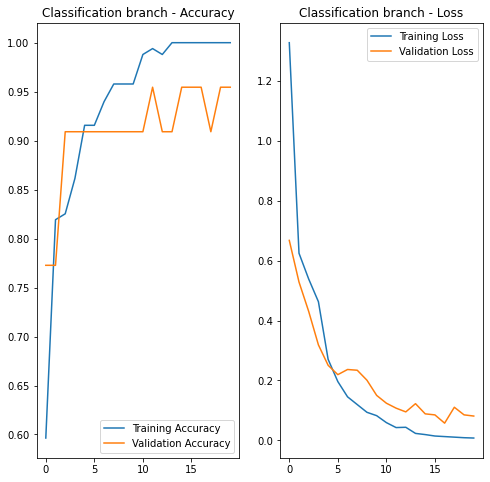

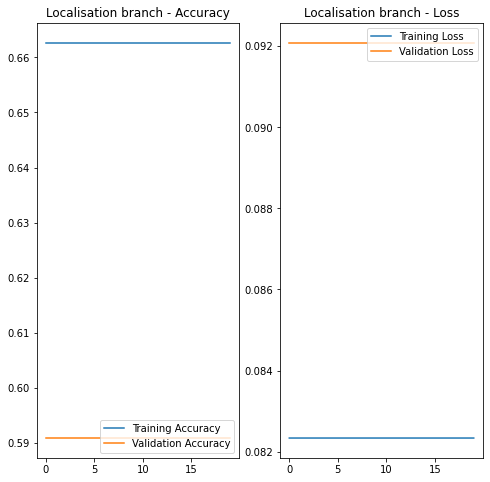

In [14]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(training_epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()



In [15]:
test_img = 'Test/20210524_000419.jpg'

img = keras.preprocessing.image.load_img(test_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = base_model.predict(img)

In [16]:
print(predictions[1][0])

[0.02212911 0.04080559 0.40266478 0.43211845]


In [17]:
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))

[4.779887571930885, 8.814007312059402, 86.97559261322021, 93.33758425712585]
tf.Tensor([0.99506265 0.00493739], shape=(2,), dtype=float32)
Predicted class: Circle


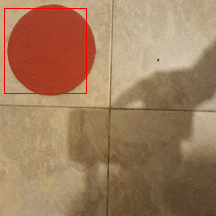

In [18]:
testimg = keras.preprocessing.image.load_img(test_img, target_size=(height, width))
draw1 = Draw(testimg)
draw1.rectangle(bbox, outline='red')
testimg

In [19]:
base_model.save('./Saved-Models/Detector')

INFO:tensorflow:Assets written to: ./Saved-Models/Detector/assets


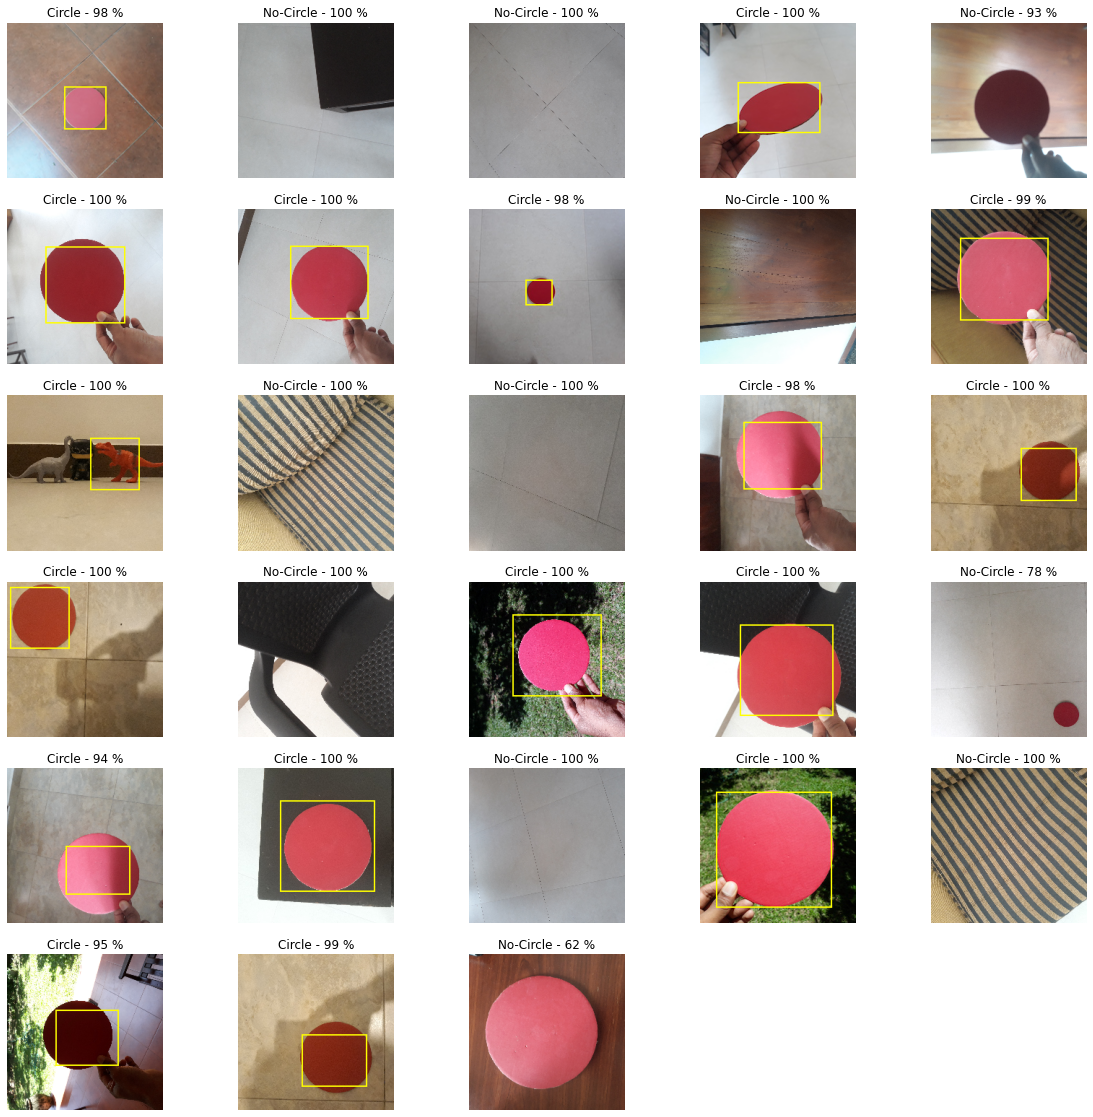

In [35]:
test_dir = pathlib.Path('Test')
img_paths = list(test_dir.glob('*.jpg'))

plt.figure(figsize=(20, 20))
#print(len(img_paths))

for i, img_path in enumerate(img_paths):
    circle_img = keras.preprocessing.image.load_img(img_path, target_size=(height, width))
    img_arr = keras.preprocessing.image.img_to_array(circle_img)
    img_arr = tf.expand_dims(img_arr, 0)
    
    predictions = base_model.predict(img_arr)
    
    score = tf.nn.softmax(predictions[0][0])
    
    percent = int(round(100*np.max(score), 0))
    class_name = classes[np.argmax(score)]
    title = "{} - {} %".format(class_name, percent)
    #print(i)
    
    bbox = predictions[1][0]
    bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
    
    if class_name == 'Circle':    
        draw1 = Draw(circle_img)
        draw1.rectangle(bbox, outline='yellow', width=2)
        #circle_img
    
    ax = plt.subplot(6, 5, i+1)
    plt.imshow(circle_img)
    plt.title(title)
    plt.axis("off")